In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 10

# plt.rc("font", family="serif",) #serif="Times"
# plt.rc("font", family= "Times New Roman")
plt.rc("font", family="serif", serif="Computer Modern")
plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("text", usetex=true)

In [3]:
include("../model-35/likelihood.jl")
include("../model-35/utill_model.jl")
include("../utill.jl")

plot_projections_prl (generic function with 1 method)

In [4]:
function hist_2d(smpls, dim_1, dim_2; nbins=40, axmin = true, axmax=true)
    smpl_tmp, smpl_w = flatview(unshaped.(smpls.v)), smpls.weight
    if axmin == true
        hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), nbins=nbins)
    else
       hist_tmp = fit(Histogram, (smpl_tmp[dim_1,:],smpl_tmp[dim_2,:]), FrequencyWeights(smpl_w), (range(axmin[1], stop=axmax[1], length=nbins), range(axmin[2], stop=axmax[2], length=nbins))) 
    end
    hist_tmp = normalize(hist_tmp, mode=:pdf) 
    return hist_tmp
end

hist_2d (generic function with 1 method)

In [5]:
β1 = 0.015
β2 = 0.0077 # (0.8/30/sqrt(12))
β3 = 0.0058 # (0.8/40/sqrt(12))

prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.19), truncated(Normal(0.2, 0.04), 0.03, 0.19)], #core
        tr_size_2 = [0.1, 0.1],
        ang_spr = [truncated(Normal(4.0, 2.0), 1.0, 8.0), truncated(Normal(4.0, 2.0), 1.0, 8.0)],
        ang_spr_2 = [2.0, 2.0],
        mixt_pow =  1.0 , 
        waist = [truncated(Normal(2.774, 0.03), 2.5, 3.6)],
        waist_2 = [2.774], # 11
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct = 1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [1, 1, 1], # 23, 24, 25, 
        resy = [1, 1, 1], # 26,27, 28, 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [27.1, 21.6, 114.0], # 31, 32, 33
        psy = [30.5, 23.4, 125.0], # 34, 35, 36
        cam4_psx = 121.8, # 37
        cam4_psy = 120.0, # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    ); 

# flat prior for the pixel size
# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.20), truncated(Normal(0.2, 0.04), 0.03, 0.20)],
#         ang_spr = [truncated(Normal(4.0, 2.0), 2.0, 7.0), truncated(Normal(4.0, 2.0), 2.0, 7.0)],
#         waist = [Normal(2.9, 0.03)],
#         algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#         algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#         cam4_ped = 4.0 .. 40.0,
#         cam4_light_fluct = 1.0 .. 3.0,
#         cam4_light_amp = 1.6 .. 9.9, 
#         resx = [1.0, 1.0, 1.0], 
#         resy = [1.0, 1.0, 1.0], 
#         cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
#         cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
#         psx = [27.1, 21.6, 114.0], # 31, 32, 33
#         psy = [30.5, 23.4, 125.0], # 34, 35, 36
#         cam4_psx = 121.8, # 37
#         cam4_psy = 120.0, # 38
#         light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
#         s_cam = [0.0, 1.478, 15.026, 23.1150],
#     );

# labels = [L"\sigma_x", L"\sigma_y", L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", L"\sigma'_x", L"\sigma'_y", L"\alpha", L"s", L"s",
#     L"\mu_x", L"\mu_x", L"\mu_x", L"\mu_x", L"\mu_y", L"\mu_y", L"\mu_y", L"\mu_y", 
#     "ped", "lf", "a", 
#     "res x", "res x", "res x", "res y", "res y", "res y", "res x", "res y", 
#     "ps x", "ps x", "ps x", "ps y", "ps y", "ps y", "ps x", "ps y", 
#     "la", "la", "la"
#     ];

labels = [
    L"\sigma_x", 
    L"\sigma_y", 
    L"\sigma'_x", 
    L"\sigma'_y", 
    L"s_w",
    L"\mu_{1,x}", 
    L"\mu_{2,x}",
    L"\mu_{3,x}", 
    L"\mu_{4,x}",
    L"\mu_{1,y}", 
    L"\mu_{2,y}",
    L"\mu_{3,y}", 
    L"\mu_{4,y}",
    L"p_4", 
    L"f_4", 
    L"i_4", 
    L"\tilde{\sigma}_{4,x}", 
    L"\tilde{\sigma}_{4,y}",
    L"i_1", 
    L"i_2", 
    L"i_3"
];

In [6]:
FPATH = "../../data/sampling_results/Benchmark-10/"

"../../data/sampling_results/Benchmark-10/"

In [7]:
readdir(FPATH)

831-element Vector{String}:
 ".ipynb_checkpoints"
 "hc-1.hdf5"
 "hc-10.hdf5"
 "hc-100.hdf5"
 "hc-101.hdf5"
 "hc-102.hdf5"
 "hc-103.hdf5"
 "hc-104.hdf5"
 "hc-105.hdf5"
 "hc-106.hdf5"
 "hc-107.hdf5"
 "hc-108.hdf5"
 "hc-109.hdf5"
 ⋮
 "lc-90.hdf5"
 "lc-91.hdf5"
 "lc-92.hdf5"
 "lc-93.hdf5"
 "lc-94.hdf5"
 "lc-95.hdf5"
 "lc-96.hdf5"
 "lc-97.hdf5"
 "lc-98.hdf5"
 "lc-99.hdf5"
 "mcmc-summary-data.jld"
 "to-delete"

In [8]:
# Plots: "lc-52.hdf5"  "hc-90.hdf5"

filename =  "lc-52.hdf5"  #readdir(FPATH)[208] # 18 - large population
smpl_tmp = bat_read(FPATH*filename).result
samples = varshape(prior).(smpl_tmp);

In [9]:
filename

# Example HC "hc-2.hdf5"
# Example LC "lc-169.hdf5"

"lc-52.hdf5"

In [10]:
smpl_vect = mode(samples)[1]

(tr_size = [0.09090959704801894, 0.11701441332751641], tr_size_2 = [0.1, 0.1], ang_spr = [4.616833960088776, 4.2251715251749244], ang_spr_2 = [2.0, 2.0], mixt_pow = 1.0, waist = [2.977206613960861], waist_2 = [2.774], algmx = [33.37023004020231, 33.94074341734349, 21.387304689678803, 35.492184345501144], algmy = [36.191257140019594, 36.73842303704753, 20.77705525279789, 34.274919931942634], cam4_ped = 22.379010807954216, cam4_light_fluct = 1.7298096970137462, cam4_light_amp = 2.55526647397976, resx = [1, 1, 1], resy = [1, 1, 1], cam4_resx = 3.7223949296542505, cam4_resy = 3.29081035531496, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [2.809157738022781, 3.848877530100539, 2.0501861748246535], s_cam = [0.0, 1.478, 15.026, 23.115])

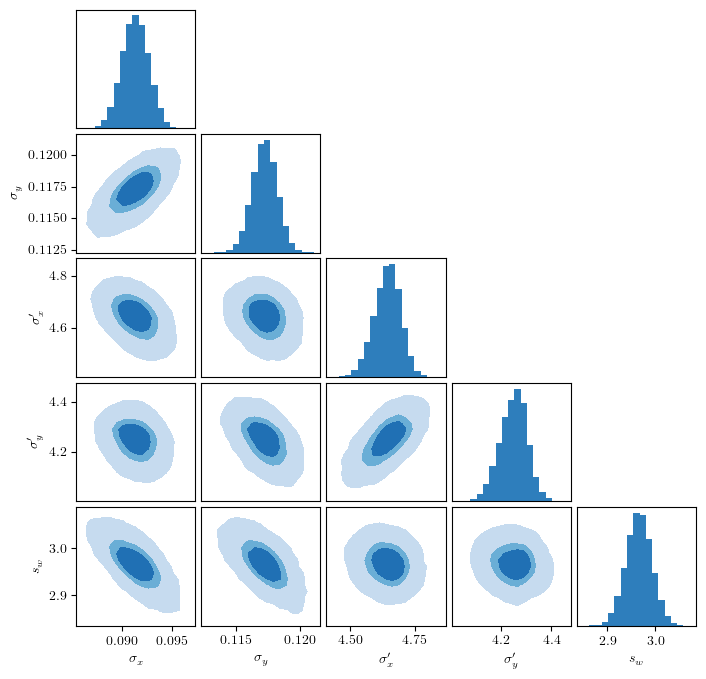

In [11]:
dims = [1,2,3,4,5]
names = labels[dims]
levels = [0.0001, 0.65, 0.9, 0.95,  1,]
# levels = [0.001, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

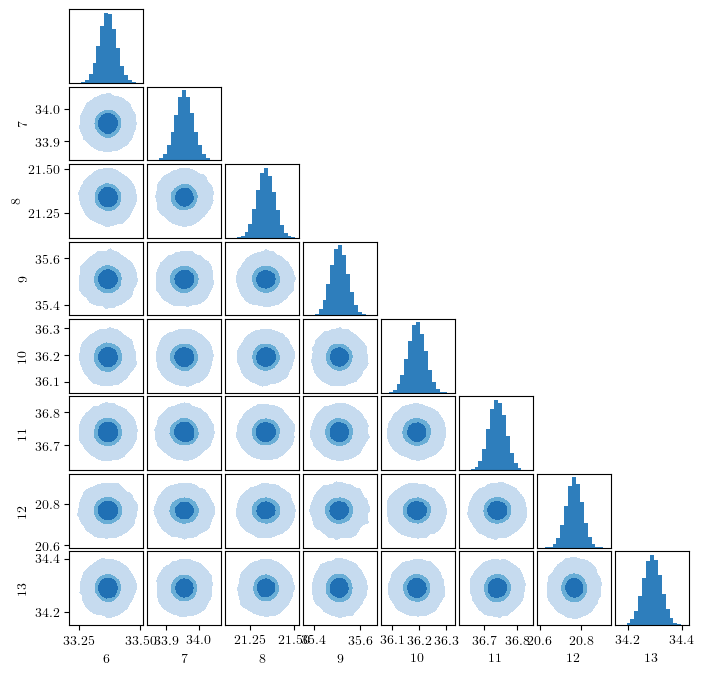

In [12]:
dims = 6:13
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

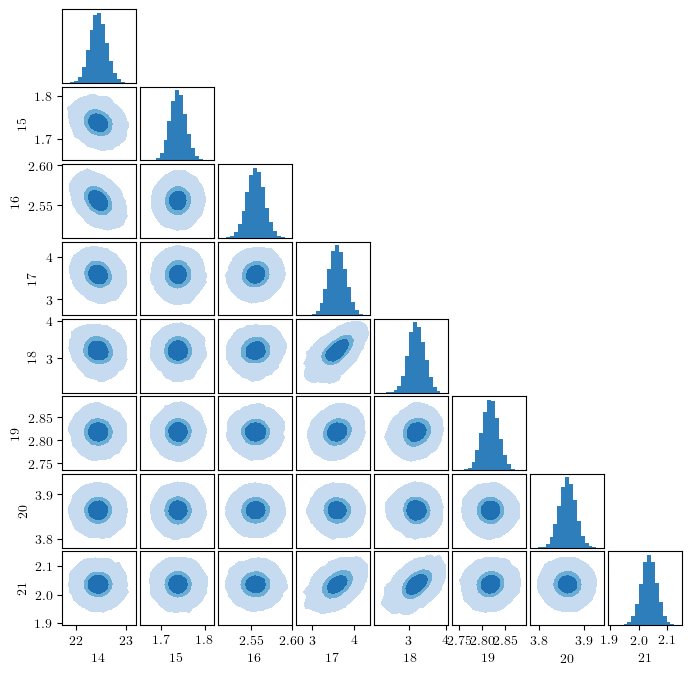

In [13]:
dims = 14:21
names = dims
levels = [0.01, 0.55, 0.9, 0.95,  1,]
# levels = [0.01, 0.65, 0.95, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

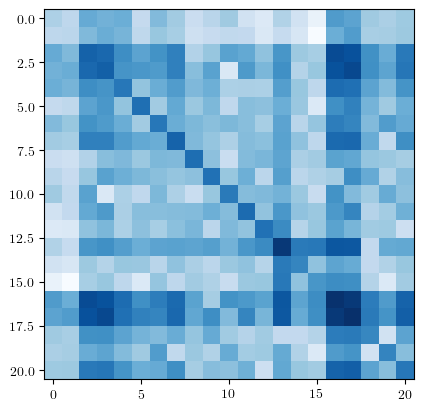

PyObject <matplotlib.image.AxesImage object at 0x7f421040ad60>

In [14]:
plt.imshow(log.(abs.(cov(flatview(unshaped.(samples.v))'))), cmap="Blues")

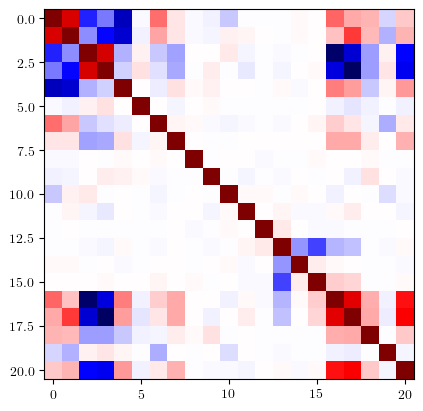

PyObject <matplotlib.image.AxesImage object at 0x7f420fa69280>

In [15]:
dt_reg = flatview(unshaped.(samples.v)) ./ std(flatview(unshaped.(samples.v)), dims=2)
dt_reg = dt_reg .- mean(dt_reg, dims=2)
dt_reg = cov(dt_reg')
max = maximum(abs.(dt_reg))

plt.imshow(dt_reg, cmap="seismic", vmin=-max, vmax=max)

In [16]:
if filename[1:2] == "hc"
    
    conv_mat = load("../../data/experiment/dataset_2/m2/conv-matrix-upd-2.jld2") 

    global conv_matrices = (
        cam_1 = conv_mat["cam_1"],
        cam_2 = conv_mat["cam_2"],
        cam_3 = conv_mat["cam_3"],
        cam_4 = conv_mat["cam_4"], 
    ) 

    images = load("../../data/experiment/dataset_2/m2/images-satur.jld2")
    event_number = parse(Int64, filename[4:end-5])

    global event = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    );
    
    images = load("../../data/experiment/dataset_2/m2/images.jld2")

    global event_nt = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    );
end

In [17]:
if filename[1:2] == "lc"
    @show "true"
    conv_mat = load("../../data/experiment/dataset_2/m1/conv-matrix-upd-2.jld2") 

    global conv_matrices = (
        cam_1 = conv_mat["cam_1"],
        cam_2 = conv_mat["cam_2"],
        cam_3 = conv_mat["cam_3"],
        cam_4 = conv_mat["cam_4"], 
    ) 

    images = load("../../data/experiment/dataset_2/m1/images-satur.jld2")
    event_number = parse(Int64, filename[4:end-5])

    global event = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    )
    
    images = load("../../data/experiment/dataset_2/m1/images.jld2")

    global event_nt = (
        cam_1 = images["cam_1"][event_number,:,:],
        cam_2 = images["cam_2"][event_number,:,:],
        cam_3 = images["cam_3"][event_number,:,:],
        cam_4 = images["cam_4"][event_number,:,:],
        population = images["charge"][event_number,:][1],
    );

end

"true" = "true"


(cam_1 = [0.0 1.0 … 14.0 5.0; 4.0 7.0 … 3.0 0.0; … ; 0.0 0.0 … 142.0 3.0; 316.0 71.0 … 2.0 0.0], cam_2 = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], cam_3 = [117.0 46.0 … 21.0 160.0; 64.0 163.0 … 5.0 35.0; … ; 140.0 100.0 … 414.0 20.0; 11.0 215.0 … 0.0 0.0], cam_4 = [18.0 17.0 … 21.0 13.0; 13.0 9.0 … 19.0 19.0; … ; 13.0 16.0 … 20.0 17.0; 15.0 14.0 … 14.0 19.0], population = 9.075499534606934)

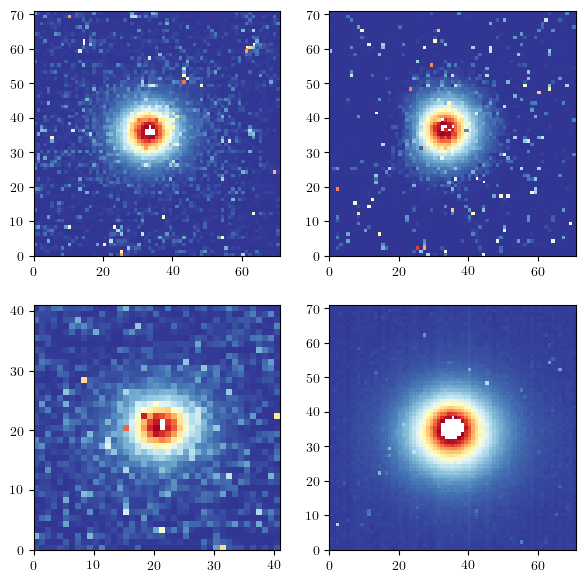

PyObject <matplotlib.collections.QuadMesh object at 0x7f421a33ae20>

In [18]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, cmap="RdYlBu_r")

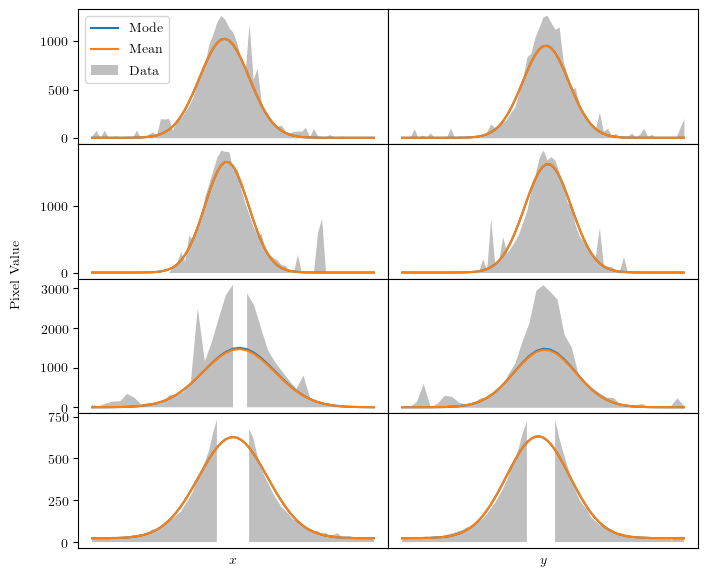

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


PyObject Text(0.04, 0.5, 'Pixel Value')

In [19]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_crossections(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

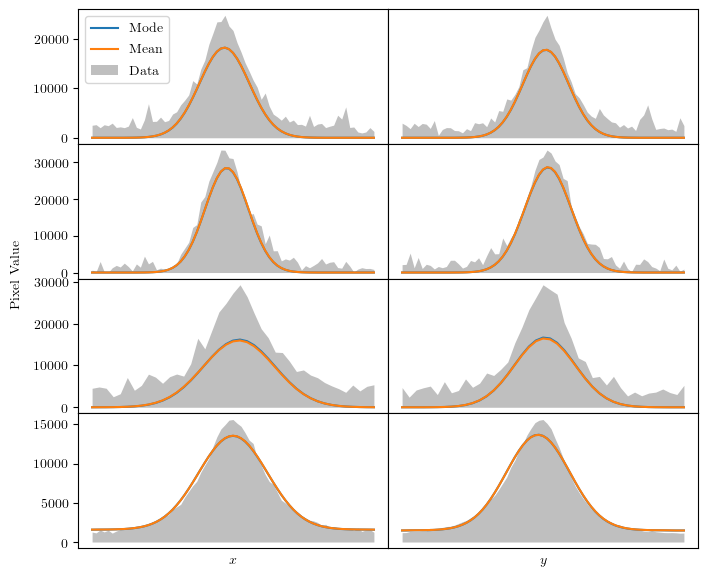

PyObject Text(0.04, 0.5, 'Pixel Value')

In [20]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_integral(params_array, event_nt, conv_matrices, colors = colors_array, labels=labels_array)

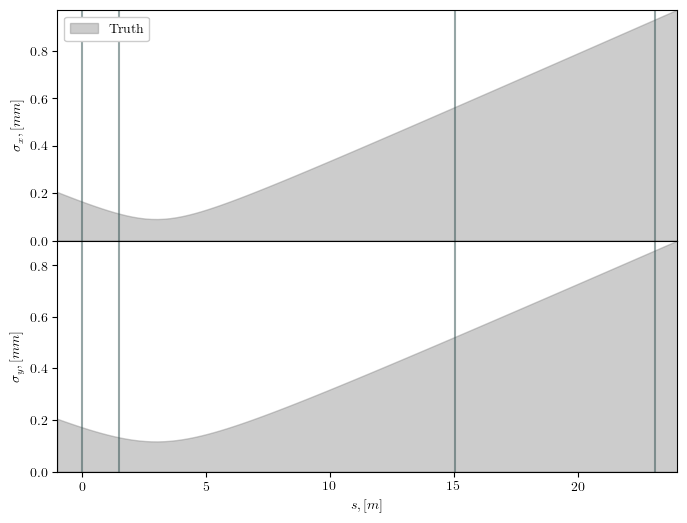

PyObject Text(0.5, 23.83700013837, '$s, [m]$')

In [21]:
params_array = [mode(samples)[1],]
colors_array = ["gray",]
labels_array = ["Truth", ]

plot_envelop_trajectory(params_array,  labels = labels_array, colors=colors_array)

In [22]:
# plot_projections(conv_matrices, event_nt, event_nt, params_array[1], isnontr = true)

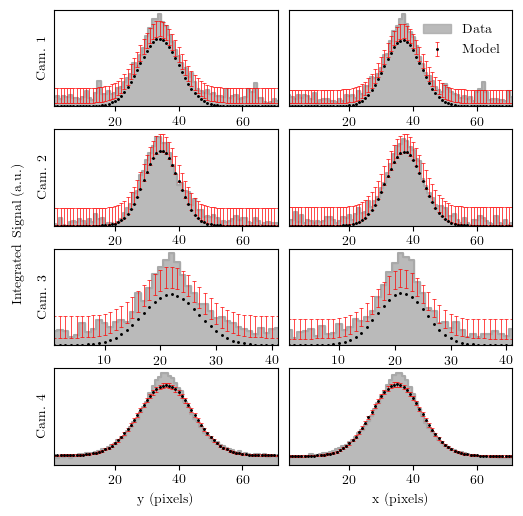

In [23]:
plot_projections(conv_matrices, event_nt, event_nt, params_array[1], 
    isnontr = true, 
    figsize=(5.905631659056317, 5.905631659056317),
    saveplot = false,
    filename = "../../plots/proj-m1-2.pdf"
)

In [24]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 9

# plt.rc("font", family="serif",) #serif="Times"
# plt.rc("font", family= "Times New Roman")
plt.rc("font", family="serif", serif="Computer Modern")
plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("text", usetex=true)

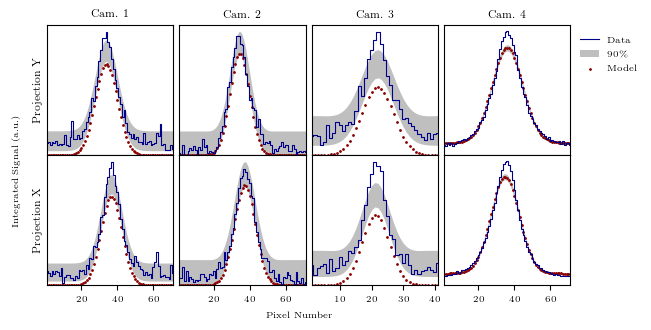

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


In [25]:
plot_projections_prl(conv_matrices, event_nt, event_nt, params_array[1], 
    isnontr = true, 
    figsize=(2*3.375, 3.375),
    saveplot = true,
    filename = "../../plots-prl/proj-m1-1.pdf"
)